
# **AlexNet Code**

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses
import numpy as np

# Data

In [2]:
# 다중 GPU 전략 정의
# strategy = tf.distribute.MirroredStrategy()

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

170498071/170498071 [==============================] - 2s 0us/step


# Model Architecture

In [4]:
model = models.Sequential()

# 1st conv layer
# model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same', input_shape=(224, 224, 3), activation='relu'))
model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same', input_shape=(32, 32, 3), activation='relu'))
# local response normalization
model.add(layers.Lambda(tf.nn.local_response_normalization))
# max-pooling
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# 2nd conv layer
model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

# 3rd conv layer
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# 4th conv layer
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# 5th layer
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
# max-pooling
# imagenet 데이터가아니라 cifar10 데이터를 사용하면서
# 이미지 크기가 너무 작아지는 문제 발생
# 남아있는 shape가 클때만 maxpooling 추가하고 지금은 패스
if model.output_shape[1] > 1 and model.output_shape[2] > 1:
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# conv -> fully connected
model.add(layers.Flatten())

# fully connected layer
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

# output layer
# cifar - 10 classes
model.add(layers.Dense(10, activation='softmax'))

# 모델 구조 출력
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 lambda (Lambda)             (None, 8, 8, 96)          0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 96)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 256)         614656    
                                                                 
 lambda_1 (Lambda)           (None, 3, 3, 256)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 256)         0         
 g2D)                                                   

# Model compile

In [14]:
# categorical_crossentropy: 원-핫 인코딩된 레이블
# sparse_categorical_crossentropy : 정수 인코딩된 레이블
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, decay=0.0005)
model.compile(optimizer=optimizer, loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# Training

In [15]:
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 30 == 29:
        return lr * 0.1
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [16]:
# with strategy.scope():
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 11s 20ms/step - loss: 2.3029 - accuracy: 0.1007 - val_loss: 2.3031 - val_accuracy: 0.1008
Epoch 2/10
313/313 [==============================] - 5s 16ms/step - loss: 2.3029 - accuracy: 0.0998 - val_loss: 2.3029 - val_accuracy: 0.0952
Epoch 3/10
313/313 [==============================] - 5s 16ms/step - loss: 2.3029 - accuracy: 0.0993 - val_loss: 2.3029 - val_accuracy: 0.0952
Epoch 4/10
313/313 [==============================] - 5s 16ms/step - loss: 2.3028 - accuracy: 0.1002 - val_loss: 2.3025 - val_accuracy: 0.1014
Epoch 5/10
313/313 [==============================] - 5s 16ms/step - loss: 2.3027 - accuracy: 0.0982 - val_loss: 2.3026 - val_accuracy: 0.0997
Epoch 6/10
313/313 [==============================] - 5s 16ms/step - loss: 2.3026 - accuracy: 0.0998 - val_loss: 2.3025 - val_accuracy: 0.1014
Epoch 7/10
313/313 [==============================] - 5s 16ms/step - loss: 2.3025 - accuracy: 0.1006 - val_loss: 2.3025 - val_accuracy: 0.0977
Epoch 8/1

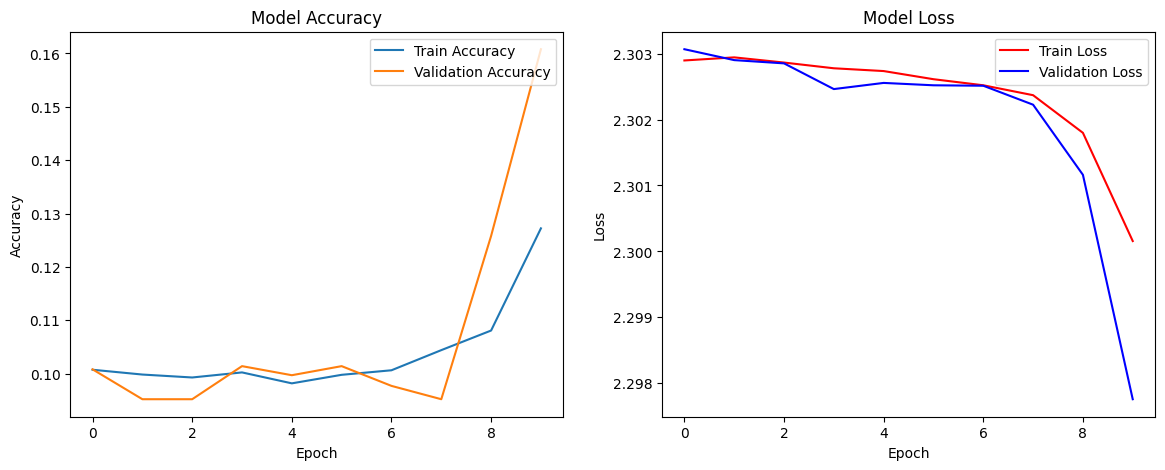

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 1st graph : accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper right')

# 2nd graph : loss
ax2.plot(history.history['loss'], label='Train Loss', color='r')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='b')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.show()